In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import joblib

In [2]:
df = pd.read_csv('liver_cirrhosis.csv')

In [3]:
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         25000 non-null  int64  
 1   Status         25000 non-null  object 
 2   Drug           25000 non-null  object 
 3   Age            25000 non-null  int64  
 4   Sex            25000 non-null  object 
 5   Ascites        25000 non-null  object 
 6   Hepatomegaly   25000 non-null  object 
 7   Spiders        25000 non-null  object 
 8   Edema          25000 non-null  object 
 9   Bilirubin      25000 non-null  float64
 10  Cholesterol    25000 non-null  float64
 11  Albumin        25000 non-null  float64
 12  Copper         25000 non-null  float64
 13  Alk_Phos       25000 non-null  float64
 14  SGOT           25000 non-null  float64
 15  Tryglicerides  25000 non-null  float64
 16  Platelets      25000 non-null  float64
 17  Prothrombin    25000 non-null  float64
 18  Stage 

In [4]:
print(df.isin(["?", "NA", ""]).sum())
print(df.dtypes)
print(df.duplicated().sum())

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64
N_Days             int64
Status            object
Drug              object
Age                int64
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage              int64
dtype: object
15361


In [5]:
categorical_features = ['Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Drug']
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

In [6]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])
df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [8]:
X = df.drop('Stage', axis=1)
y = df['Stage']
y = y - 1  # Adjust labels to start from 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(preprocessor.fit_transform(X_train), y_train)

RandomForestClassifier(random_state=42)

In [10]:
selector = SelectFromModel(rf, prefit=True)
X_train_selected = selector.transform(preprocessor.transform(X_train))
X_test_selected = selector.transform(preprocessor.transform(X_test))

In [11]:
class_weights = {0: 1, 1: 5, 2: 5} 
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=class_weights,enable_categorical=True)

In [12]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [13]:
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='accuracy')

In [14]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 1.0}


In [15]:
best_model = grid_search.best_estimator_
best_model.fit(X_train_selected, y_train)

c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [16]:
y_pred = best_model.predict(X_test_selected)
y_pred_proba = best_model.predict_proba(X_test_selected)

In [17]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_proba, multi_class='ovr'))

Accuracy: 0.961
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95      1653
           1       0.94      0.97      0.96      1688
           2       0.98      0.97      0.97      1659

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

Confusion Matrix:
 [[1568   62   23]
 [  44 1631   13]
 [  19   34 1606]]
AUC-ROC Score: 0.9951408012062583


In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import plot_importance
from sklearn.model_selection import learning_curve
import seaborn as sns

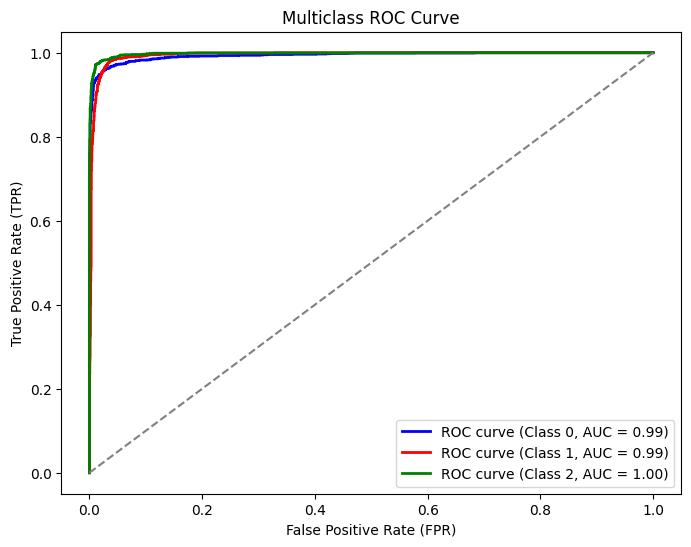

In [19]:
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (Class {i}, AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.show()

<Figure size 1000x800 with 0 Axes>

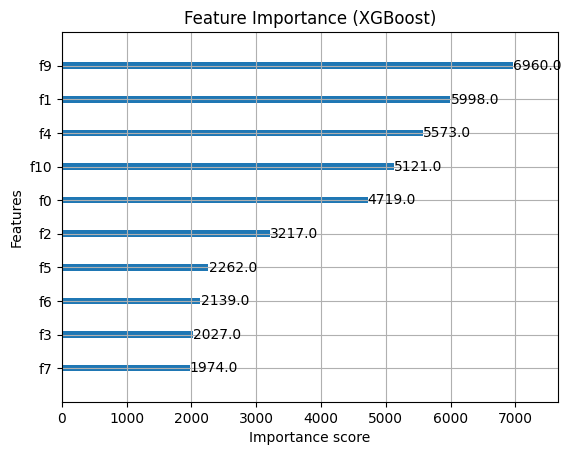

In [20]:
plt.figure(figsize=(10, 8))
plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Feature Importance (XGBoost)')
plt.show()

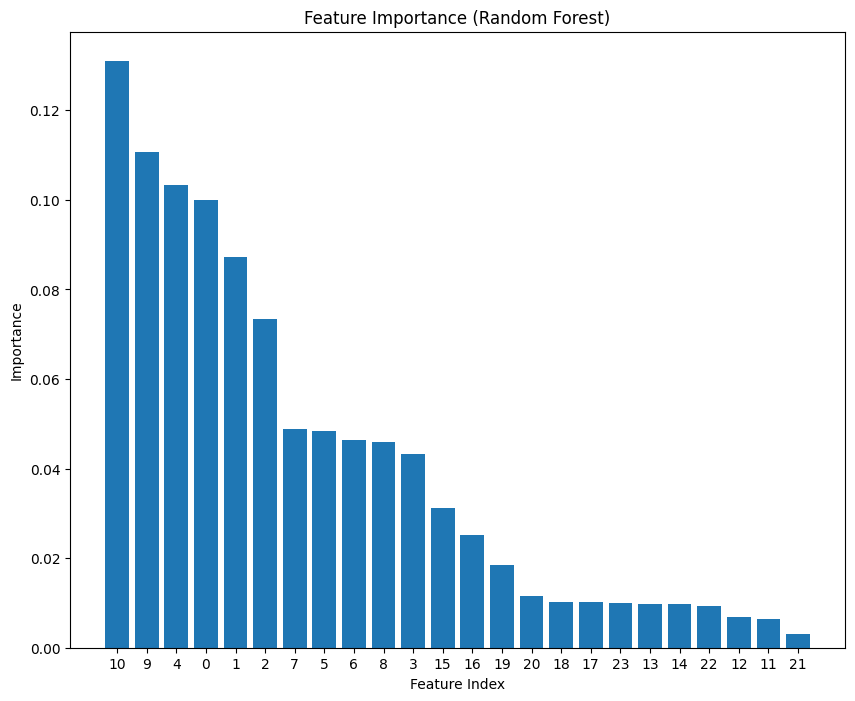

In [21]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]


plt.figure(figsize=(10, 8))
plt.title('Feature Importance (Random Forest)')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), indices)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()

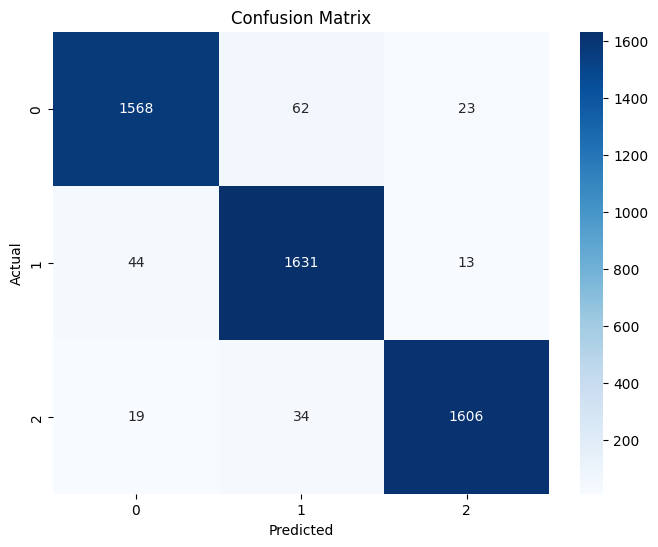

In [22]:
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

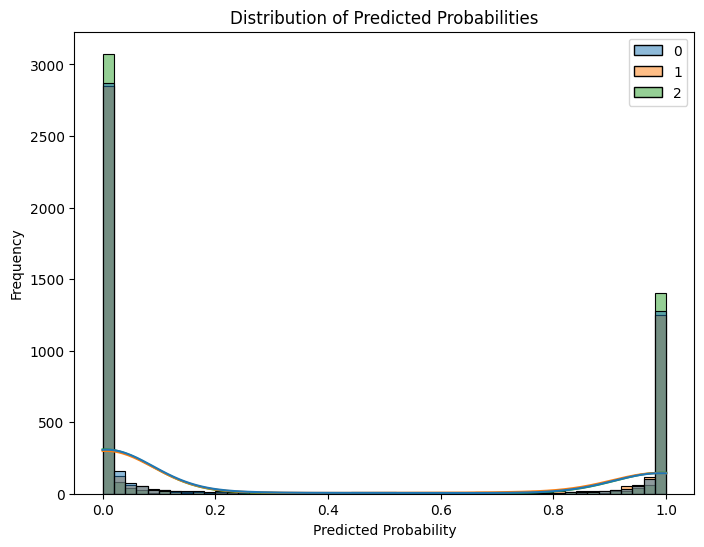

In [23]:
plt.figure(figsize=(8, 6))
sns.histplot(y_pred_proba, bins=50, kde=True)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities')
plt.show()

c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:53:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iterat

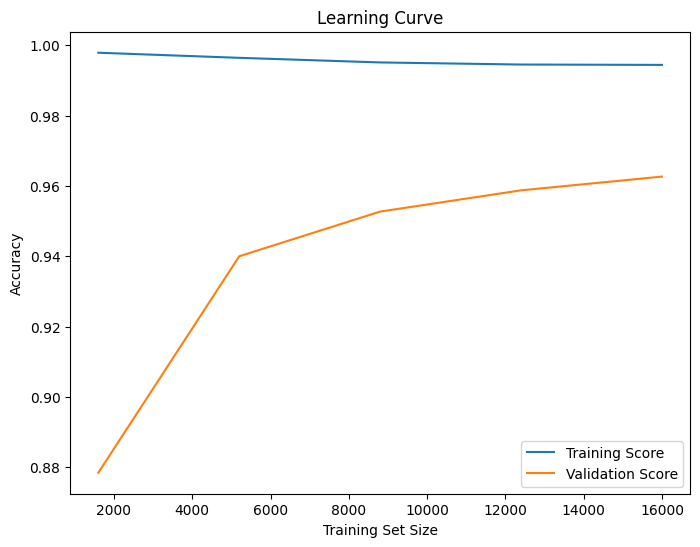

In [24]:
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend(loc='best')
plt.show()

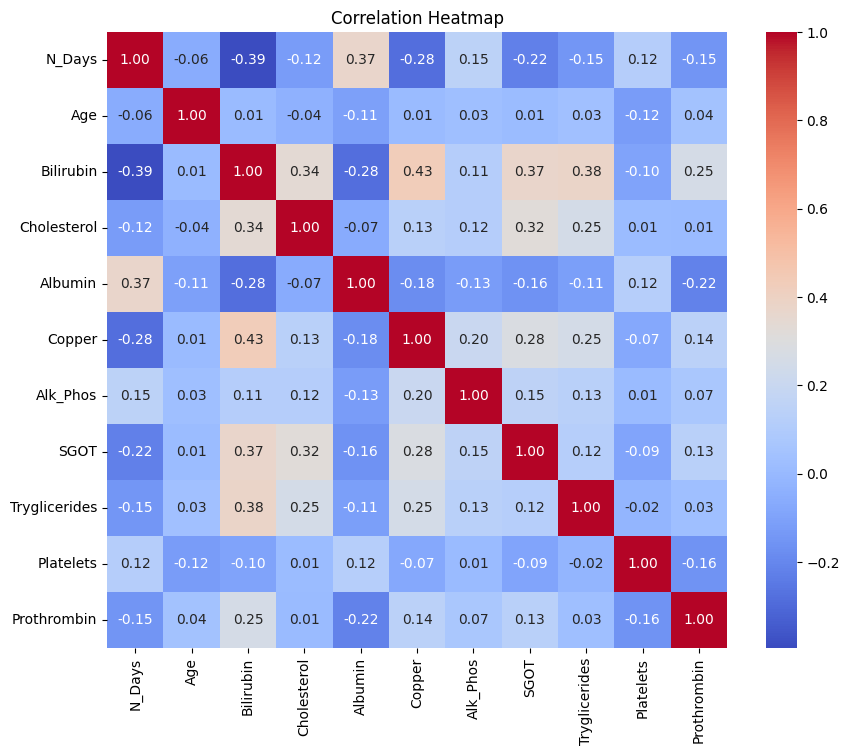

In [25]:
corr = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [26]:
cv_scores = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\PRINCE SOMPURA\OneDrive\Documents\GitHub\liver_cirrhosis_stage_detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:54:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iterat

Cross-Validation Accuracy Scores: [0.96475 0.96375 0.95825 0.96025 0.96625]
Mean CV Accuracy: 0.96265


In [27]:
joblib.dump(best_model, 'best_liver_cirrhosis_model.pkl')
joblib.dump(selector, 'feature_selector.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [28]:
import joblib
import pandas as pd

# Input data
data = {
    'Sex': ['Male'],
    'Ascites': ['No'],
    'Hepatomegaly': ['No'],
    'Spiders': ['Yes'],
    'Edema': ['None'],
    'Drug': ['No'],
    'N_Days': [500],
    'Age': [45],
    'Bilirubin': [1.5],
    'Cholesterol': [250],
    'Albumin': [3.5],
    'Copper': [100],
    'Alk_Phos': [120],
    'SGOT': [35],
    'Tryglicerides': [150],
    'Platelets': [250],
    'Prothrombin': [12]
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(data)

# Load the preprocessor, feature selector, and model
preprocessor = joblib.load('preprocessor.pkl')
feature_selector = joblib.load('feature_selector.pkl')
model = joblib.load('best_liver_cirrhosis_model.pkl')

# Step 1: Preprocess the input data
preprocessed_data = preprocessor.transform(input_df)

# Step 2: Select the relevant features
selected_features = feature_selector.transform(preprocessed_data)

# Step 3: Make predictions using the model
predictions = model.predict(selected_features)

# Output the predictions
print("Predictions:", predictions)

Predictions: [2]


In [29]:
# Modified input data
data = {
    'Sex': ['Female'],  # Changed to 'Female'
    'Ascites': ['Yes'],  # Changed to 'Yes'
    'Hepatomegaly': ['Yes'],  # Changed to 'Yes'
    'Spiders': ['No'],  # Changed to 'No'
    'Edema': ['Moderate'],  # Changed to 'Moderate'
    'Drug': ['Yes'],  # Changed to 'Yes'
    'N_Days': [200],  # Reduced number of days
    'Age': [65],  # Increased age
    'Bilirubin': [3.0],  # Increased bilirubin level
    'Cholesterol': [180],  # Reduced cholesterol level
    'Albumin': [2.5],  # Reduced albumin level
    'Copper': [200],  # Increased copper level
    'Alk_Phos': [300],  # Increased alkaline phosphatase level
    'SGOT': [70],  # Increased SGOT level
    'Tryglicerides': [250],  # Increased triglycerides level
    'Platelets': [150],  # Reduced platelet count
    'Prothrombin': [8]  # Reduced prothrombin time
}

# Create a DataFrame from the modified input data
input_df = pd.DataFrame(data)

# Preprocess, select features, and predict
preprocessed_data = preprocessor.transform(input_df)
selected_features = feature_selector.transform(preprocessed_data)
predictions = model.predict(selected_features)

# Output the predictions
print("Predictions:", predictions)

Predictions: [1]
